In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import keras
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras import layers
from collections import defaultdict
import pickle

### Import Libraries

In [3]:
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
PROJECT_ID, DATASET_ID, TABLE_ID = "intern-project-415606", "Criminal_Dataset", "criminal_data_electra"
bigquery_client = bigquery.Client(project=PROJECT_ID)

In [5]:
# read the (original) data from the bigquery
def read_bq(project_id, dataset_id, table_id):

    query = f"""
        SELECT *
        FROM {project_id}.{dataset_id}.{table_id}
    """

    query_job = bigquery_client.query(query)

    # Convert the result into a Pandas DataFrame
    df = query_job.to_dataframe()

    return df

In [6]:
dataset = read_bq(PROJECT_ID, DATASET_ID, TABLE_ID)
dataset.head()

,extract_id,text,ner_label,sequence
0,6468,dụng,other,463
1,6469,Tứ,other,1515
2,6469,Chính,other,2437
3,6469,040.99,other,3006
4,6469,coi.,other,3038


### Transformer block layer

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Token and Position Embedding Layer

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

### Data Preprocessing

In [7]:
dataset

,extract_id,text,ner_label,sequence
0,6528,này.,I-PERSON,8845
1,6528,danh:,other,9372
2,6529,ng,other,1075
3,6529,tranh,other,1400
4,6530,428/KLGĐMT-,other,1045
...,...,...,...,...
48782637,12252,người,other,1652
48782638,12252,K,other,1868
48782639,12253,được,other,772
48782640,12253,mỗi,other,1541


In [8]:
dataset['ner_label'].value_counts()

ner_label
other              46950152
I-PERSON             487255
I-ORGANIZATION       437948
B-PERSON             356561
I-LOCATION           277356
B-LOCATION           175297
B-ORGANIZATION        77069
I-MISCELLANEOUS       14601
B-MISCELLANEOUS        6403
Name: count, dtype: int64

In [9]:
columns = dataset['ner_label'].unique()
columns

array(['I-PERSON', 'other', 'B-PERSON', 'I-ORGANIZATION', 'B-LOCATION',
       'B-ORGANIZATION', 'I-LOCATION', 'I-MISCELLANEOUS',
       'B-MISCELLANEOUS'], dtype=object)

In [9]:
#mapping
label_map = {'[PAD]': 0,
            'other': 1,
            'I-ORGANIZATION': 2,
            'B-LOCATION': 3,
            'I-LOCATION': 4,
            'B-ORGANIZATION': 5,
            'B-PERSON': 6,
            'I-PERSON': 7,
            'B-MISCELLANEOUS': 8,
            'I-MISCELLANEOUS': 9}
label_map

{'[PAD]': 0,
 'other': 1,
 'I-ORGANIZATION': 2,
 'B-LOCATION': 3,
 'I-LOCATION': 4,
 'B-ORGANIZATION': 5,
 'B-PERSON': 6,
 'I-PERSON': 7,
 'B-MISCELLANEOUS': 8,
 'I-MISCELLANEOUS': 9}

In [8]:
# Replace numeric labels with NER labels
dataset.loc[:, 'ner_label'] = dataset['ner_label'].map(label_map)

dataset

,extract_id,text,ner_label,sequence
0,6845,Honda,1,1806
1,6845,Điều,1,1972
2,6845,vụ,1,4375
3,6846,hành,1,638
4,6847,trú:,3,334
...,...,...,...,...
49392306,12419,hiện,1,856
49392307,12419,cá,1,2590
49392308,12419,gặp,1,3099
49392309,12419,giả,1,3239


In [12]:
dataset.describe()

,extract_id,sequence
count,48782642.0,48782642.0
mean,6149.144342,2829.390171
std,3549.814823,3154.447278
min,0.0,1.0
25%,3062.0,992.0
50%,6152.0,2037.0
75%,9229.0,3555.0
max,12298.0,44559.0


In [9]:
agg_func = lambda x: list(x)
# Grouping the dataset by 'extract_id' and aggregating the 'text' and 'self_label' columns into lists
grouped_data = dataset.sort_values(['extract_id', 'sequence']).groupby('extract_id').agg({'text': agg_func, 'ner_label': agg_func, 'sequence': agg_func}).reset_index()
# Converting the grouped data into a dictionary
dataset_group = {
    'id': grouped_data['extract_id'].tolist(),
    'token': grouped_data['text'].tolist(),
    'ner_label': grouped_data['ner_label'].tolist(),
    'seq': grouped_data['sequence'].tolist()
}

# Printing the first group for verification
print('Group ID:', dataset_group['id'][1])
print('Token:', dataset_group['token'][1])
print('NER Tag:', dataset_group['ner_label'][1])
print('seq:', dataset_group['seq'][1])

Group ID: 1
Token: ['<Page:1>TÒA', 'ÁN', 'NHÂN', 'DÂN', 'CỘNG', 'HÒA', 'XÃ', 'HỘI', 'CHỦ', 'NGHĨA', 'VIỆT', 'NAM', 'THÀNH', 'PHỐ', 'THỦ', 'DẦU', 'MỘT', 'Độc', 'lập', '–', 'Tự', 'do', '–', 'Hạnh', 'phúc', 'TỈNH', 'BÌNH', 'DƯƠNG', 'Bản', 'án', 'số:', '27/2022/HS-ST', 'Ngày:', '24-02-2022.', 'NHÂN', 'DANH', 'NƯỚC', 'CỘNG', 'HÒA', 'XÃ', 'HỘI', 'CHỦ', 'NGHĨA', 'VIỆT', 'NAM', 'TÒA', 'ÁN', 'NHÂN', 'DÂN', 'THÀNH', 'PHỐ', 'THỦ', 'DẦU', 'MỘT,', 'TỈNH', 'BÌNH', 'DƯƠNG', '-', 'Thành', 'phần', 'Hội', 'đồng', 'xét', 'xử', 'sơ', 'thẩm', 'gồm', 'có:', 'Thẩm', 'phán', '–', 'Chủ', 'tọa', 'phiên', 'tòa:', 'Ông', 'Lê', 'Minh', 'Đạo.', 'Các', 'Hội', 'thẩm', 'nhân', 'dân:', '1/', 'Ông', 'Trương', 'Ngọc', 'Điệp.', '2/', 'Bà', 'Trương', 'Thị', 'Thu', 'Cúc.', '-', 'Thư', 'ký', 'phiên', 'tòa:', 'Bà', 'Trương', 'Thị', 'Kiều', 'Diễm', '–', 'Thư', 'ký', 'Tòa', 'án', 'nhân', 'dân', 'thành', 'phố', 'Thủ', 'Dầu', 'Một.', '-', 'Đại', 'diện', 'Viện', 'kiểm', 'sát', 'nhân', 'dân', 'thành', 'phố', 'Thủ', 'Dầu', 'Một', 't

In [10]:
def split_into_chunks(lst, chunk_size):
    """Splits a list into smaller chunks of a specified size."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Initialize a new dataset dictionary
split_dataset = {
    'id': [],
    'token': [],
    'ner_label': []
}

# Iterate over each group in the original grouped dataset
for idx, (group_id, tokens, labels) in enumerate(zip(dataset_group['id'], dataset_group['token'], dataset_group['ner_label'])):
    # Split tokens and labels into chunks of 512
    token_chunks = list(split_into_chunks(tokens, 512))
    label_chunks = list(split_into_chunks(labels, 512))

    # Add each chunk to the new dataset dictionary
    for chunk_idx in range(len(token_chunks)):
        split_dataset['id'].append(group_id)  # Keep the same group_id for each chunk
        split_dataset['token'].append(token_chunks[chunk_idx])
        split_dataset['ner_label'].append(label_chunks[chunk_idx])

# Print the first chunk for verification
print('Group ID:', split_dataset['id'][0])
print('Token:', split_dataset['token'][0])
print('NER Tag:', split_dataset['ner_label'][0])


Group ID: 0
Token: ['<Page:1>TÒA', 'ÁN', 'NHÂN', 'DÂN', 'CỘNG', 'HÒA', 'XÃ', 'HỘI', 'CHỦ', 'NGHĨA', 'VIỆT', 'NAM', 'HUYỆN', 'ANH', 'SƠN', 'Độc', 'lập', '–', 'Tự', 'do', '–', 'Hạnh', 'phúc', 'TỈNH', 'NGHỆ', 'AN', 'Số:', '17/QĐ', '–', 'TA', 'Anh', 'Sơn,', 'ngày', '18', 'tháng', '5', 'năm', '2021', 'QUYẾT', 'ĐỊNH', 'Áp', 'dụng', 'biện', 'pháp', 'xử', 'lý', 'hành', 'chính', 'đưa', 'và', 'cơ', 'sở', 'cai', 'nghiện', 'bắt', 'buộc', 'TÒA', 'ÁN', 'NHÂN', 'DÂN', 'HUYỆN', 'ANH', 'SƠN,', 'TỈNH', 'NGHỆ', 'AN', 'Với', 'thành', 'phần', 'tiến', 'hành', 'phiên', 'họp', 'gồm', 'có:', '1.', 'Thẩm', 'phán:', 'Ông', 'Phan', 'Văn', 'Phú', '2.', 'Thư', 'ký', 'phiên', 'họp:', 'Ông', 'Phạm', 'Mạnh', 'Cường', 'Ngày', '18', 'tháng', '5', 'năm', '2021,', 'tại', 'trụ', 'sở', 'Tòa', 'án', 'nhân', 'dân', 'huyện', 'A,', 'tỉnh', 'N', 'tiến', 'hành', 'phiên', 'họp', 'xem', 'xét,', 'quyết', 'định', 'áp', 'dụng', 'biện', 'pháp', 'xử', 'lý', 'hành', 'chính', 'đưa', 'vào', 'cơ', 'sở', 'cai', 'nghiện', 'bắt', 'buộc', 'theo

Average length: 3966.390926091552
Highest length: 44559
Average length of each sublist: 3966.390926091552
Median for sublist lengths: 3308.0
Maximum length of each sublist: 44559
Percentage of data less than length of 5000: 78.5267094885763


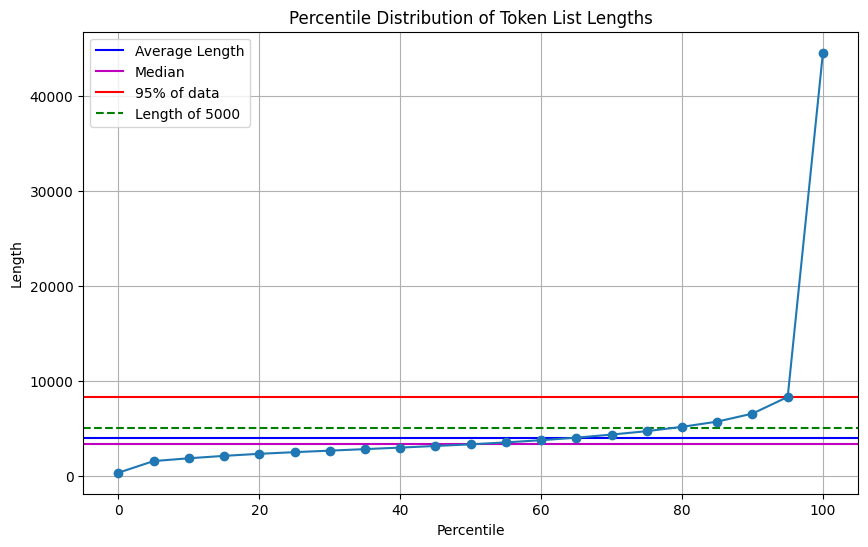

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average length and highest length of token lists in dataset_group
total_length, highest_length = 0, 0
for token_list in dataset_group['token']:
    # Calculate the length of the current token list
    length = len(token_list)

    # Update total length
    total_length += length

    # Update highest length if necessary
    if length > highest_length:
        highest_length = length

# Calculate average length
if dataset_group['token']:
    average_length = total_length / len(dataset_group['token'])
else:
    average_length = 0

print("Average length:", average_length)
print("Highest length:", highest_length)

# Plotting percentile distribution of token list lengths
lengths = [len(sublist) for sublist in dataset_group['token']]
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(lengths, percentiles)
avg_lengths = np.mean(lengths)
quartiles = np.percentile(lengths, [25, 50, 75])
max_lengths = max(lengths)
percentage_less_than_5000 = np.mean(np.array(lengths) <= 5000) * 100

print("Average length of each sublist:", avg_lengths)
print("Median for sublist lengths:", quartiles[1])
print("Maximum length of each sublist:", max_lengths)
print("Percentage of data less than length of 5000:", percentage_less_than_5000)

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_lengths, color='b', linestyle='-', label='Average Length')
plt.axhline(y=quartiles[1], color='m', linestyle='-', label='Median')
plt.axhline(y=percentile_values[-2], color='r', linestyle='-', label='95% of data')
plt.axhline(y=5000, color='g', linestyle='--', label='Length of 5000')  # Added line for length 256
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Length')
plt.title('Percentile Distribution of Token List Lengths')
plt.grid(True)
plt.legend()
plt.show()


Average length: 481.4234876147242
Highest length: 512
Average length of each sublist: 481.4234876147242
Median for sublist lengths: 512.0
Maximum length of each sublist: 512
Percentage of data less than length of 5000: 100.0


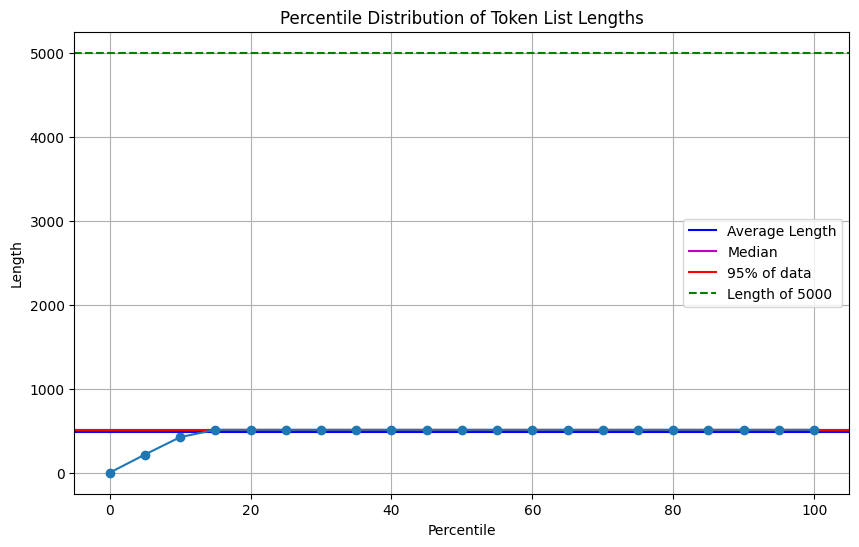

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average length and highest length of token lists in dataset_group
total_length, highest_length = 0, 0
for token_list in split_dataset['token']:
    # Calculate the length of the current token list
    length = len(token_list)

    # Update total length
    total_length += length

    # Update highest length if necessary
    if length > highest_length:
        highest_length = length

# Calculate average length
if dataset_group['token']:
    average_length = total_length / len(split_dataset['token'])
else:
    average_length = 0

print("Average length:", average_length)
print("Highest length:", highest_length)

# Plotting percentile distribution of token list lengths
lengths = [len(sublist) for sublist in split_dataset['token']]
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(lengths, percentiles)
avg_lengths = np.mean(lengths)
quartiles = np.percentile(lengths, [25, 50, 75])
max_lengths = max(lengths)
percentage_less_than_5000 = np.mean(np.array(lengths) <= 5000) * 100

print("Average length of each sublist:", avg_lengths)
print("Median for sublist lengths:", quartiles[1])
print("Maximum length of each sublist:", max_lengths)
print("Percentage of data less than length of 5000:", percentage_less_than_5000)

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_lengths, color='b', linestyle='-', label='Average Length')
plt.axhline(y=quartiles[1], color='m', linestyle='-', label='Median')
plt.axhline(y=percentile_values[-2], color='r', linestyle='-', label='95% of data')
plt.axhline(y=5000, color='g', linestyle='--', label='Length of 5000')  # Added line for length 256
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Length')
plt.title('Percentile Distribution of Token List Lengths')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
dataset_group = split_dataset

In [18]:
# drop the data > 5000
print("Number of remaining entries before filtering:", len(dataset_group['id']))
# Create empty lists to store filtered data
filtered_ids = []
filtered_tokens = []
filtered_self_tags = []

# Iterate through the token lists and their corresponding ids and self_tags
for id, token_list, self_tag_list in zip(dataset_group['id'], dataset_group['token'], dataset_group['ner_label']):
    # Check if the length of the token list is less than or equal to 1024
    if len(token_list) <= 5000:
        # If the length is within the limit, append the id, token list, and self tag list to the filtered lists
        filtered_ids.append(id)
        filtered_tokens.append(token_list)
        filtered_self_tags.append(self_tag_list)

# Update the dataset_group dictionary with the filtered lists
dataset_group['id'] = filtered_ids
dataset_group['token'] = filtered_tokens
dataset_group['ner_label'] = filtered_self_tags

# Print the lengths after filtering
print("Number of remaining entries after filtering:", len(dataset_group['id']))


Number of remaining entries before filtering: 101330
Number of remaining entries after filtering: 101330


In [12]:
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict

# Assuming dataset_group is already constructed as in your previous code

# Convert dataset_group to a DataFrame
import pandas as pd
dataset_df = pd.DataFrame(dataset_group)

# Split data into train and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Create train and test datasets
#train_dataset = Dataset.from_pandas(train_df)
# since we are training all we got, so we just use all the data
train_dataset = Dataset.from_pandas(dataset_df)
test_dataset = Dataset.from_pandas(test_df)

# Construct DatasetDict
dataset_dict = DatasetDict({'train': train_dataset, 'test': test_dataset})

# Print DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['id', 'token', 'ner_label'],
        num_rows: 102602
    })
    test: Dataset({
        features: ['id', 'token', 'ner_label', '__index_level_0__'],
        num_rows: 20521
    })
})


In [13]:
print(type(dataset_dict['train']['ner_label'][0][0]))

<class 'int'>


### Turn into tensorflow acceptable dtype

In [14]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_label"]
            tokens = record["token"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )
try:
    os.mkdir('./data')
except:
    print('directory exist')
export_to_file("./data/crime_train.txt", dataset_dict['train'])
export_to_file("./data/crime_val.txt", dataset_dict['test'])

In [6]:
def make_tag_lookup_table():
    ner_labels = {'[PAD]': 0,
                  'other': 1,
                  'I-ORGANIZATION': 2,
                  'B-LOCATION': 3,
                  'I-LOCATION': 4,
                  'B-ORGANIZATION': 5,
                  'B-PERSON': 6,
                  'I-PERSON': 7,
                  'B-MISCELLANEOUS': 8,
                  'I-MISCELLANEOUS': 9}
    return dict(zip(range(len(ner_labels)), ner_labels))

mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'other', 2: 'I-ORGANIZATION', 3: 'B-LOCATION', 4: 'I-LOCATION', 5: 'B-ORGANIZATION', 6: 'B-PERSON', 7: 'I-PERSON', 8: 'B-MISCELLANEOUS', 9: 'I-MISCELLANEOUS'}


In [16]:
# show how many token in total (train)
s = 0
for d in dataset_dict['train']['token']:
    s += len(d)
print(s)

48879466


In [ ]:
def generate_tokens(dataset):
    for tokens in dataset:
        for token in tokens:
            yield token

def count_tokens(token_generator):
    token_counter = defaultdict(int)
    for token in token_generator:
        token_counter[token] += 1
    return token_counter

token_generator = generate_tokens(dataset_dict["train"]["token"])
counter = count_tokens(token_generator)

print(len(counter))

num_tags = len(mapping)
vocab_size = 400000

# Sort the items in the defaultdict by value (count), in descending order
sorted_items = sorted(counter.items(), key=lambda item: item[1], reverse=True)

# Take the (vocab_size - 2) most common tokens
vocabulary = [token for token, count in sorted_items[:vocab_size - 2]]

# Save the list to a file
with open('./data/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)

# The StringLookup class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

326118


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/data/vocabulary.pkl /content/drive/MyDrive/NER/vocabulary.pkl

In [ ]:
!cp /content/data/crime_train.txt /content/drive/MyDrive/NER/crime_train.txt
!cp /content/data/crime_val.txt /content/drive/MyDrive/NER/crime_val.txt

In [10]:
with open('./data/vocabulary.pkl', 'rb') as f:
    loaded_list = pickle.load(f)
    # The StringLookup class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=loaded_list)

In [11]:
train_data = tf.data.TextLineDataset("./data/crime_train.txt")
val_data = tf.data.TextLineDataset("./data/crime_val.txt")

In [12]:
print(list(train_data.take(1).as_numpy_iterator()))

[b'512\t<Page:1>T\xc3\x92A\t\xc3\x81N\tNH\xc3\x82N\tD\xc3\x82N\tC\xe1\xbb\x98NG\tH\xc3\x92A\tX\xc3\x83\tH\xe1\xbb\x98I\tCH\xe1\xbb\xa6\tNGH\xc4\xa8A\tVI\xe1\xbb\x86T\tNAM\tHUY\xe1\xbb\x86N\tANH\tS\xc6\xa0N\t\xc4\x90\xe1\xbb\x99c\tl\xe1\xba\xadp\t\xe2\x80\x93\tT\xe1\xbb\xb1\tdo\t\xe2\x80\x93\tH\xe1\xba\xa1nh\tph\xc3\xbac\tT\xe1\xbb\x88NH\tNGH\xe1\xbb\x86\tAN\tS\xe1\xbb\x91:\t17/Q\xc4\x90\t\xe2\x80\x93\tTA\tAnh\tS\xc6\xa1n,\tng\xc3\xa0y\t18\tth\xc3\xa1ng\t5\tn\xc4\x83m\t2021\tQUY\xe1\xba\xbeT\t\xc4\x90\xe1\xbb\x8aNH\t\xc3\x81p\td\xe1\xbb\xa5ng\tbi\xe1\xbb\x87n\tph\xc3\xa1p\tx\xe1\xbb\xad\tl\xc3\xbd\th\xc3\xa0nh\tch\xc3\xadnh\t\xc4\x91\xc6\xb0a\tv\xc3\xa0\tc\xc6\xa1\ts\xe1\xbb\x9f\tcai\tnghi\xe1\xbb\x87n\tb\xe1\xba\xaft\tbu\xe1\xbb\x99c\tT\xc3\x92A\t\xc3\x81N\tNH\xc3\x82N\tD\xc3\x82N\tHUY\xe1\xbb\x86N\tANH\tS\xc6\xa0N,\tT\xe1\xbb\x88NH\tNGH\xe1\xbb\x86\tAN\tV\xe1\xbb\x9bi\tth\xc3\xa0nh\tph\xe1\xba\xa7n\tti\xe1\xba\xbfn\th\xc3\xa0nh\tphi\xc3\xaan\th\xe1\xbb\x8dp\tg\xe1\xbb\x93m\tc\xc3\xb3:

### NER model class

In [6]:
@keras.utils.register_keras_serializable(package='CustomModels')
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=512, embed_dim=256, num_heads=2, ff_dim=32, **kwargs
    ):
        super().__init__()
        self.num_tags = num_tags
        self.vocab_size = vocab_size
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

    def get_config(self):
        config = {
            'num_tags': self.num_tags,
            'vocab_size': self.vocab_size,
            'maxlen': self.maxlen,
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
        }
        base_config = super(NERModel, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)

    return tokens, tags


def convert_to_ids(tokens):
    return lookup_layer(tokens)

# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32

train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lookup_layer(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lookup_layer(x), y))
    .padded_batch(batch_size)
)
num_tags = 10
vocab_size = 400000
ner_model = NERModel(num_tags, vocab_size, embed_dim=256, num_heads=4, ff_dim=64)

In [ ]:
for a, b in train_dataset:
    print(a)
    print(len(b[0]))
    break

### custom loss function

In [11]:
from tensorflow.keras.losses import Reduction
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, reduction=Reduction.AUTO, name="custom_ner_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=self.reduction  # Pass the reduction argument here
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

loss = CustomNonPaddingTokenLoss()

### compile and fit model

In [17]:
from keras.losses import SparseCategoricalCrossentropy

# Compile the model with a specified loss function and optimizer
ner_model.compile(optimizer="adam", loss=loss)
#ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


Epoch 1/3
3173/3173 [==============================] - 417s 128ms/step - loss: 0.1684
Epoch 2/3
3173/3173 [==============================] - 362s 114ms/step - loss: 0.1351
Epoch 3/3
3173/3173 [==============================] - 362s 114ms/step - loss: 0.1232


In [20]:
def prediction_and_casting(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        if len(x[0]) > 3135:
            continue
        output = ner_model.predict(x, verbose=0)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)
    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]
    print(len(predicted_tags), len(real_tags))
    return predicted_tags, real_tags
    #evaluate(real_tags, predicted_tags)
y_pred, y_val = prediction_and_casting(val_dataset)

9780959 9780959


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

def calculate_metrics(y_true, y_pred, labels):
    # Mapping labels to numeric indices
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    y_true_mapped = [label_to_index[label] for label in y_true]
    y_pred_mapped = [label_to_index[label] for label in y_pred]

    # Overall metrics
    accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
    precision = precision_score(y_true_mapped, y_pred_mapped, average='weighted')
    recall = recall_score(y_true_mapped, y_pred_mapped, average='weighted', zero_division=0)  # Set zero_division to 0
    f1 = f1_score(y_true_mapped, y_pred_mapped, average='weighted')

    # Per-label metrics
    per_label_accuracy = {}
    per_label_precision = {}
    per_label_recall = {}
    per_label_f1 = {}

    for label in labels:
        label_index = label_to_index[label]
        label_indices = [i for i, true_label in enumerate(y_true) if true_label == label]
        if len(label_indices) > 0:
            per_label_accuracy[label] = accuracy_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices])
            per_label_precision[label] = precision_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted')
            per_label_recall[label] = recall_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted', zero_division=0)  # Set zero_division to 0
            per_label_f1[label] = f1_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted')
        else:
            per_label_accuracy[label] = 0
            per_label_precision[label] = 0
            per_label_recall[label] = 0
            per_label_f1[label] = 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_label_accuracy': per_label_accuracy,
        'per_label_precision': per_label_precision,
        'per_label_recall': per_label_recall,
        'per_label_f1': per_label_f1,
        'index_to_label': index_to_label
    }

#labels
labels = ['[PAD]', 'other', 'I-ORGANIZATION', 'B-LOCATION', 'I-LOCATION', 'B-ORGANIZATION', 'B-PERSON', 'I-PERSON', 'B-MISCELLANEOUS','I-MISCELLANEOUS']

metrics = calculate_metrics(y_val, y_pred, labels)

# Constructing table
table_data = []
for label in labels:
    table_data.append([label,
                       metrics['per_label_accuracy'][label],
                       metrics['per_label_precision'][label],
                       metrics['per_label_recall'][label],
                       metrics['per_label_f1'][label]])
overall_accuracy = calculate_metrics(y_val, y_pred, labels)
print("Overall Accuracy:".ljust(20), overall_accuracy['accuracy'])
print("Overall Precision:".ljust(20), overall_accuracy['precision'])
print("Overall Recall:".ljust(20), overall_accuracy['recall'])
print("Overall F1-score:".ljust(20), overall_accuracy['f1'])
print(tabulate(table_data, headers=["Label", "Accuracy", "Precision", "Recall", "F1-score"], tablefmt="grid"))


Overall Accuracy:    0.9684571829817505
Overall Precision:   0.9652379790065565
Overall Recall:      0.9684571829817505
Overall F1-score:    0.9580464051618722
+-----------------+------------+-------------+------------+------------+
| Label           |   Accuracy |   Precision |     Recall |   F1-score |
+=================+============+=============+============+============+
| [PAD]           | 0          |           0 | 0          |  0         |
+-----------------+------------+-------------+------------+------------+
| other           | 0.999119   |           1 | 0.999119   |  0.999559  |
+-----------------+------------+-------------+------------+------------+
| I-ORGANIZATION  | 0.228307   |           1 | 0.228307   |  0.371743  |
+-----------------+------------+-------------+------------+------------+
| B-LOCATION      | 0.357797   |           1 | 0.357797   |  0.527026  |
+-----------------+------------+-------------+------------+------------+
| I-LOCATION      | 0.270625   |     

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
ner_model.save("./drive/MyDrive/NER/ner_model_electra.keras")

In [25]:
!cp /content/data/vocabulary.pkl /content/drive/MyDrive/NER/vocabulary.pkl

In [13]:
import re
import pickle
import keras
import tensorflow as tf
from tensorflow.keras.losses import Reduction
import numpy as np

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.AUTO, name="custom_ner_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=self.reduction
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    return tokens, tags

def lookup(tokens):
    # Load the list from the file
    with open('/content/drive/MyDrive/NER/vocabulary.pkl', 'rb') as f:
        loaded_list = pickle.load(f)
    # The StringLookup class will convert tokens to token IDs
    lookup_layer = keras.layers.StringLookup(vocabulary=loaded_list)

    # No need to lowercase Vietnamese characters
    return lookup_layer(tokens)

def format_datatype(data):
    tokens =  [re.sub(r'[;,]', '', d) for d in data.split(' ')]
    #default is 0, since is for prediction
    ner_tags = [0 for d in data.split(' ')]

    #tab to separate
    string_input = str(len(tokens))+ "\t"+ "\t".join(tokens)+ "\t"+ "\t".join(map(str, ner_tags))
    string_input = tf.data.Dataset.from_tensor_slices([string_input])


    finalize_input = (string_input.map(map_record_to_training_data)
                      .map(lambda x, y: (lookup(x),  y))
                      .padded_batch(1)
                      )
    return finalize_input

def prediction(data):
    # Register the custom loss function with TensorFlow
    tf.keras.utils.get_custom_objects()['CustomNonPaddingTokenLoss'] = CustomNonPaddingTokenLoss
    # Load model
    loaded_model = keras.models.load_model("/content/drive/MyDrive/NER/ner_model_electra.keras")

    all_predicted_tag_ids = []

    for x, _ in data:
        print("Input Tensor Info:")
        print("Data Type:", x.dtype)
        print("Shape:", x.shape)
        output = loaded_model(x, training=False)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])
        all_predicted_tag_ids.append(predictions)

    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    ner_labels = ['[PAD]', 'other', 'I-ORGANIZATION', 'B-LOCATION', 'I-LOCATION', 'B-ORGANIZATION', 'B-PERSON', 'I-PERSON', 'B-MISCELLANEOUS','I-MISCELLANEOUS']

    mapping =  dict(zip(range(len(ner_labels)), ner_labels))
    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]

    return predicted_tags

#sample_input = "1/ Trần Văn T, sinh ngày 01 tháng 01 năm 1987 tại Quảng Nam; Nơi cư trú: thôn 04, xã TG, huyện Bắc Trà My, tỉnh Quảng Nam; nghề nghiệp: nông; trình độ văn hoá: 03/12; dân tộc: Cadong; giới tính: nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Trần Văn Tiếu và bà Thanh Thị Liên; vợ tên Phạm Thị Hiếm và 02 con; tiền án, tiền sự: không; Bị cáo bị áp dụng biện pháp ngăn chặn: “Cấm đi khỏi nơi cư trú”, có mặt tại phiên tòa. 2/ Đinh Tấn M, sinh ngày 21 tháng 6 năm 1995 tại Quảng Nam; Nơi cư trú: thôn 04, xã TG, huyện Bắc Trà My, tỉnh Quảng Nam; nghề nghiệp: nông; trình độ"
#sample_input = "Hello world, my name is John, I live in New York, my birthday is 10/02/1990."
#sample_input = "Nguyễn Quốc H, tên gọi khác: Không; sinh ngày 27 tháng 3 năm 1997 tại Đà Nẵng. Nơi ĐKHKTT: Thôn Q, xã H, huyện H, thành phố Đà Nẵng. Chỗ ở: Tổ 5 thôn Q, xã H, huyện H, thành phố Đà Nẵng; Nghề nghiệp: Không; trình độ văn hoá (học vấn): 12/12; dân tộc: Kinh; giới tính: Nam; tôn giáo: Phật giáo; quốc tịch: Việt Nam; con ông Nguyễn C, sinh năm: 1967 và bà Võ Thị L (chết); vợ Nguyễn Thị Thanh H, sinh năm 1997, có 01 con sinh năm 2020; gia đình có 03 anh em, bị cáo là con thứ nhất. Tiền án, tiền sự: Không; Nhân thân: Ngày 28/9/2015, bị Tòa án nhân dân thành phố Đà Nẵng xử phạt 04 năm tù giam về tội “Vận chuyển trái phép chất ma túy” theo bản án số 212/2015/HSPT. Chấp hành án xong ngày 15/7/2018, đã nộp tiền án phí. Bị cáo bị tạm giữ tại Nhà tạm giữ Công an quận Hải Châu từ ngày 18/5/2021, có mặt tại phiên tòa. "
sample_input = """<Page:1>TÒA ÁN NHÂN DÂN CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM
HUYỆN ANH SƠN Độc lập – Tự do – Hạnh phúc
TỈNH NGHỆ AN
Số: 17/QĐ – TA Anh Sơn, ngày 18 tháng 5 năm 2021
QUYẾT ĐỊNH
Áp dụng biện pháp xử lý hành chính đưa và cơ sở cai nghiện bắt buộc
TÒA ÁN NHÂN DÂN HUYỆN ANH SƠN, TỈNH NGHỆ AN
Với thành phần tiến hành phiên họp gồm có:
1. Thẩm phán: Ông Phan Văn Phú
2. Thư ký phiên họp: Ông Phạm Mạnh Cường
Ngày 18 tháng 5 năm 2021, tại trụ sở Tòa án nhân dân huyện A, tỉnh N tiến
hành phiên họp xem xét, quyết định áp dụng biện pháp xử lý hành chính đưa vào cơ
sở cai nghiện bắt buộc theo Quyết định mở phiên họp số 17/QĐ – TA ngày 12 tháng
5 năm 2021 đối với:
Họ và tên: Nguyễn Văn C – Giới tính: Nam
Sinh ngày: 25/01/1994
Dân tộc: Kinh; Tôn giáo: Thiên chúa giáo; Trình độ văn hóa: 9/12
Nơi cư trú: thôn 12, xã T, huyện A, tỉnh N
Nghề nghiệp: Lao động tự do
Tiền án, tiền sự: Không
Con ông: Nguyễn Văn Trung; con bà: Nguyễn Thị Hà.
Có mặt tại phiên họp
Có sự tham gia của:
1. Đại diện cơ quan đề nghị: Ông Nguyễn Quốc Hoàn – Chức vụ: Phó
trưởng phòng Lao động- Thương binh và xã hội huyện A.
2. Đại diện Viện kiểm sát nhân dân huyện A tham gia phiên họp: Ông
Phan Hiếu Thảo – Kiểm sát viên
NHẬN THẤY
Ngày 25 tháng 12 năm 2020, chủ tịch Ủy ban nhân dân xã T, huyện A, tỉnh N
ra Quyết định áp dụng biện pháp giáo dục tại địa phương do hành vi sử dụng chất ma
túy với thời hạn 03(Ba) tháng kể từ ngày 25/12/2010 đến ngày 25/3/2021 đối với
Nguyễn Văn C. Tuy nhiên, ngày 24/02/2021 Nguyễn Văn C tiếp tục sử dụng chất ma"""
result = prediction(format_datatype(sample_input))
print(result)
wt = sample_input.split(' ')
print(wt)
for i in range(len(result)):
    if result[i] != 'other' and result[i] != '[PAD]':
        print(result[i], wt[i])
print(len(result))

Input Tensor Info:
Data Type: <dtype: 'int64'>
Shape: (1, 305)
['other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 

In [14]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/NER/ner_model_electra.keras")

embedding_layer = loaded_model.embedding_layer

In [15]:
def transform_and_insert(name):
    embedding_vectors = embedding_layer(lookup([name]))

    embedding_vector_list = embedding_vectors.numpy().tolist()[0]

    return embedding_vector_list

In [21]:
transform_and_insert('Nguyễn Văn C')

[0.028426330536603928,
 0.30270126461982727,
 0.019681092351675034,
 0.018420375883579254,
 0.31391987204551697,
 0.09674146771430969,
 0.035992227494716644,
 -0.09991629421710968,
 -0.1420634686946869,
 -0.16000066697597504,
 -0.057663142681121826,
 0.04134564846754074,
 -0.030173413455486298,
 -0.02928289771080017,
 -0.053423456847667694,
 -0.13528132438659668,
 -0.02098764479160309,
 0.32742905616760254,
 0.0711052417755127,
 0.06556638330221176,
 -0.10915609449148178,
 0.2761329710483551,
 0.22825321555137634,
 -0.10500223934650421,
 0.0710277333855629,
 -0.06992080807685852,
 -0.036823444068431854,
 -0.10704509913921356,
 -0.10904338955879211,
 -0.016140669584274292,
 0.11923746764659882,
 0.19193722307682037,
 -0.04619358479976654,
 -0.02109728753566742,
 0.07589330524206161,
 -0.1085682287812233,
 0.049186643213033676,
 0.12428893148899078,
 -0.1254844069480896,
 0.00497724674642086,
 -0.02966829389333725,
 0.05037324130535126,
 -0.038221992552280426,
 0.01877039670944214,
 0.06

In [16]:
from scipy.spatial.distance import cosine

In [17]:
a = transform_and_insert('Nguyễn Văn Đ')

In [18]:
b = transform_and_insert('Nguyễn Văn C')

In [19]:
c = transform_and_insert('Cao Thị B')

In [20]:
print("similarity a b:", 1 - cosine(a, b))
print("similarity a c:", 1 - cosine(a, c))
print("similarity b c:", 1 - cosine(b, c))

similarity a b: 1
similarity a c: 1
similarity b c: 1


In [ ]:
d = transform_and_insert('Matt')

In [ ]:
print("similarity a b:", 1 - cosine(a, d))
print("similarity a c:", 1 - cosine(b, d))
print("similarity b c:", 1 - cosine(c, d))